In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pandas as pd
import joblib

from rl_analysis.plotting import setup_plotting_env, clean_ticks, savefig
from tqdm.auto import tqdm

## Load in the data

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

# Load in raw data and normalize

In [5]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], "syllable_stats_photometry_offline.toml")
)
use_syllables = [
    int(k)
    for k, v in syllable_stats["syllable_to_sorted_idx"].items()
    if v < syllable_stats["truncate"]
]

In [ ]:
from cycler import cycler

In [7]:
spinograms = joblib.load(
    os.path.join(raw_dirs["misc"],"spinograms.p")
)

In [8]:
ar_mat = pd.read_parquet(
    os.path.join(proc_dirs["closed_loop_behavior"],"behavioral-distance.parquet")
)

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [10]:
ar_mat.columns = [int(_) for _ in ar_mat.columns]

In [11]:
angle_lim = 0.1
angle_mapping = lambda x: (x - -angle_lim) / (angle_lim - -angle_lim)
angle_cmap = plt.matplotlib.cm.coolwarm

In [12]:
base_color = angle_cmap(spinograms[27]["theta"].mean())
angle_colors = np.linspace(-angle_lim, angle_lim, 100)

In [13]:
zscale = lambda x: x * 0.1
xscale = lambda x: x * 0.005

In [14]:
setup_plotting_env()

In [15]:
joint_syllable_map = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "joint_syllable_map.toml")
)
joint_syllable_map = {int(k): v for k, v in joint_syllable_map.items()}

In [16]:
joint_labels = [joint_syllable_map[_] for _ in use_syllables]
original_labels = use_syllables

In [17]:
use_labels = "original"

/tmp/ipykernel_1592778/1729615719.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(


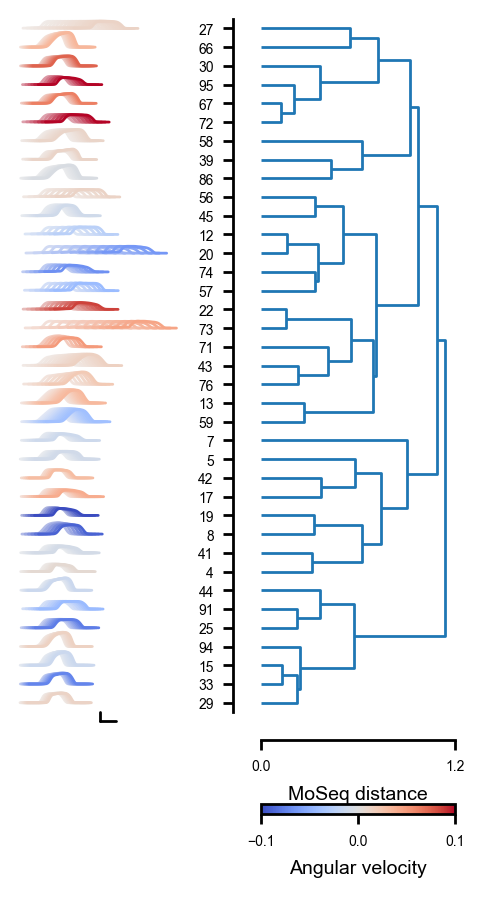

In [18]:
fig, ax = plt.subplots(1, figsize=(1.25, 6))
dn = dendrogram(
    linkage(
        squareform(ar_mat.loc[use_syllables, use_syllables].values),
        method="weighted",
        optimal_ordering=True,
    ),
    orientation="right",
    labels=joint_labels if use_labels == "joint" else original_labels,
    color_threshold=0,
)

sns.despine(offset=10)
clean_ticks(ax, "x", precision=1, zero_symmetry=False)
ax.set_xlabel("MoSeq distance")
cur_offset = -5.0
xoffset = -1
plt_zscale = zscale(50)
plt_xscale = xscale(20)

ax.plot(
    [xoffset] * 2,
    [cur_offset, cur_offset + plt_zscale],
    clip_on=False,
    color=plt.rcParams["axes.edgecolor"],
)
ax.plot(
    [xoffset, xoffset + plt_xscale],
    [cur_offset] * 2,
    clip_on=False,
    color=plt.rcParams["axes.edgecolor"],
)


for _syllable in dn["leaves"]:
    cur_offset += 10.0
    _syllable = use_syllables[_syllable]
    npoints = spinograms[_syllable]["x"].shape[1]
    base_color = angle_cmap(angle_mapping(spinograms[_syllable]["theta"][:5].mean()))
    custom_cycler = cycler(
        "color", sns.light_palette(base_color, n_colors=npoints + 3)[3:]
    )
    ax.set_prop_cycle(custom_cycler)
    ax.plot(
        xscale(spinograms[_syllable]["x"]) - 1.5,
        zscale(spinograms[_syllable]["z"]) + cur_offset,
        clip_on=False,
    )


norm = plt.matplotlib.colors.Normalize(vmin=-angle_lim, vmax=angle_lim)
sm = plt.cm.ScalarMappable(cmap=angle_cmap, norm=norm)
sm.set_array([])
fig.colorbar(
    sm,
    ticks=np.linspace(-angle_lim, angle_lim, 3),
    shrink=1,
    pad=0.1,
    location="bottom",
    label="Angular velocity",
)
plt.show()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], f"moseq_dendrogram_with_spinograms_labels-{use_labels}"),
    bbox_inches="tight",
)